In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flower-photos/flower_photos/validation/dandelion/4632863567_5f9af7de97_n.jpg
/kaggle/input/flower-photos/flower_photos/validation/dandelion/14368895004_c486a29c1e_n.jpg
/kaggle/input/flower-photos/flower_photos/validation/dandelion/4721773235_429acdf496_n.jpg
/kaggle/input/flower-photos/flower_photos/validation/dandelion/9029756865_db8891807a_n.jpg
/kaggle/input/flower-photos/flower_photos/validation/dandelion/3419172904_7708414ae9_n.jpg
/kaggle/input/flower-photos/flower_photos/validation/dandelion/10486992895_20b344ce2d_n.jpg
/kaggle/input/flower-photos/flower_photos/validation/dandelion/3554435478_1a7ab743e9_n.jpg
/kaggle/input/flower-photos/flower_photos/validation/dandelion/13807932364_673b7f1c1c_n.jpg
/kaggle/input/flower-photos/flower_photos/validation/dandelion/7249354462_21925f7d95_n.jpg
/kaggle/input/flower-photos/flower_photos/validation/dandelion/9646730031_f3d5014416_n.jpg
/kaggle/input/flower-photos/flower_photos/validation/dandelion/17280886635_e384d91300_n

In [5]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [6]:
# Required imports
import os # For working  with directories and file paths
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt  # For displaying images
from tensorflow.keras.utils import *
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import data as tf_data
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random

In [7]:
# Path to the dataset
dataset_path = '/kaggle/input/flower-photos'

# Walk through the dataset and count images
total_images = 0
for root, dirs, files in os.walk(dataset_path):
    total_images += len([f for f in files if f.endswith(('.jpg'))])

print("Total number of images:", total_images)

Total number of images: 3670


([0, 1, 2, 3, 4],
 [Text(0, 0, 'daisy'),
  Text(1, 0, 'dandelion'),
  Text(2, 0, 'roses'),
  Text(3, 0, 'sunflowers'),
  Text(4, 0, 'tulips')])

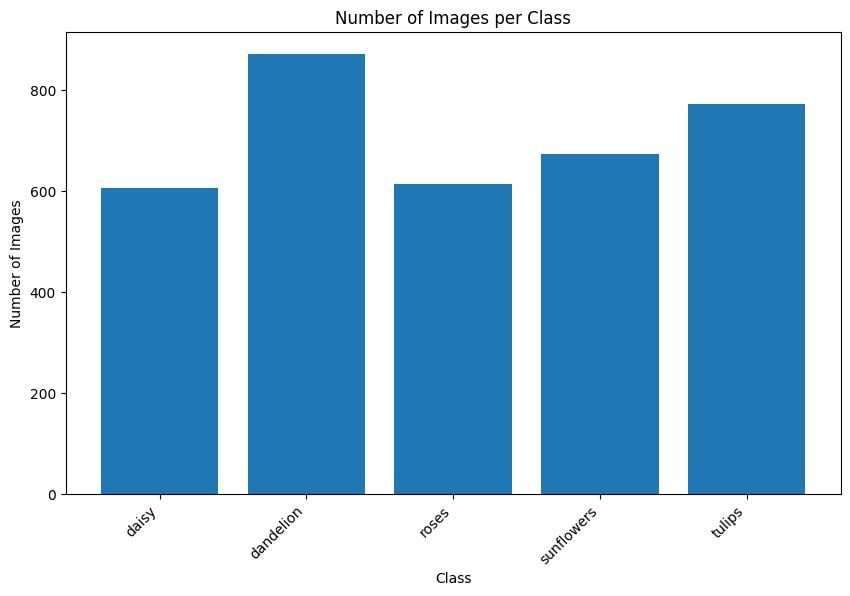

In [8]:
# Initialize an empty dictionary to keep track of the count of images for each class
class_counts = {}

# Traverse through the dataset and tally the number of images for each class
for root, dirs, files in os.walk(dataset_path):
    if len(dirs) == 0:  # Indicates a class folder
        class_name = os.path.basename(root)  # Extract the class name from the folder
        # Count the number of image files (with extensions .jpg, .png, or .jpeg)
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        class_counts[class_name] = len(image_files)

# Sort the dictionary of class counts by class names for consistent plotting
sorted_classes = sorted(class_counts.items())

# Separate the class names and their corresponding image counts for plotting
class_names = [item[0] for item in sorted_classes]
counts = [item[1] for item in sorted_classes]

# Generate a bar plot to visualize the distribution of images per class
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.bar(class_names, counts)  # Create a bar chart
plt.xlabel('Class')  # Label the x-axis
plt.ylabel('Number of Images')  # Label the y-axis
plt.title('Number of Images per Class')  # Set the title of the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better reada


In [9]:
train_path = '/kaggle/input/flower-photos/flower_photos/train'
valid_path ='/kaggle/input/flower-photos/flower_photos/validation'
test_path = '/kaggle/input/flower-photos/flower_photos/test'

In [10]:
# Define a function to count images in a specified directory path
def count_images(path):
    count = 0  # Initialize the count of images
    for root, dirs, files in os.walk(path):
        # Increment the count by the number of image files found in the current directory
        count += len([f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))])
    return count  # Return the total count of images

# Count images in the train, validation, and test sets
train_count = count_images(train_path)  # Count images in the train set
valid_count = count_images(valid_path)  # Count images in the validation set
test_count = count_images(test_path)  # Count images in the test set

# Display the counts of images in each dataset
print("Train set count:", train_count)  # Print the count of images in the train set
print("Validation set count:", valid_count)  # Print the count of images in the validation set
print("Test set count:", test_count)  # Print the count of images in the test set


Train set count: 3540
Validation set count: 80
Test set count: 50


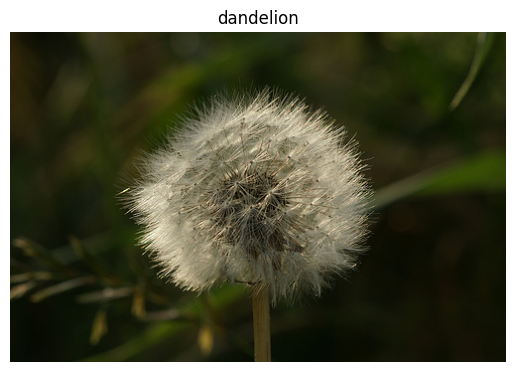

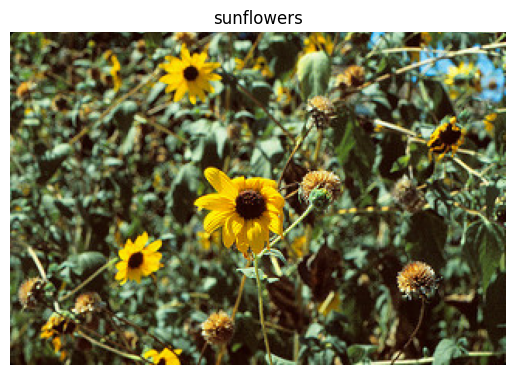

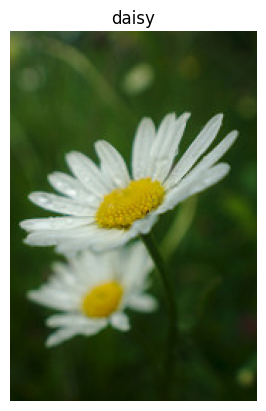

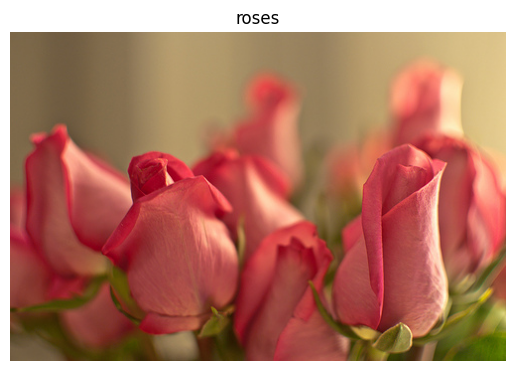

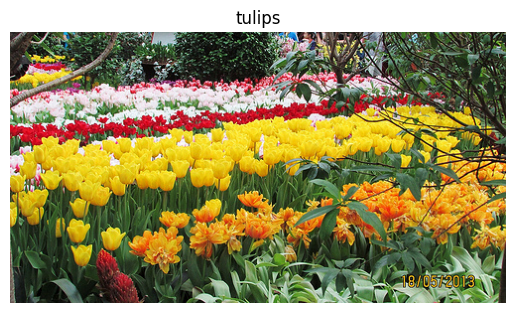

In [11]:
# Define the directory containing training images
train_directory = train_path

# Retrieve the list of subdirectories, each representing a class
class_directories = os.listdir(train_directory)

# Display one image from each class
for class_name in class_directories:
    # Form the path to the current class directory
    current_class_dir = os.path.join(train_directory, class_name)
    # Retrieve the list of image files in the current class directory
    image_files = os.listdir(current_class_dir)

    # Load and display the first image from the current class if available
    if len(image_files) > 0:
        # Construct the path to the first image in the class directory
        image_path = os.path.join(current_class_dir, image_files[0])
        # Load the image
        image = load_img(image_path)

        # Display the image with the class name as the title
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')  # Hide axis
        plt.show()  # Display the image

**Investigate Visually whether there are any corrupted images or not.**


In [12]:
# Function to check if an image is corrupted
def is_image_corrupted(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Check if the image is valid
        return False  # Not corrupted
    except (IOError, SyntaxError):
        return True  # Corrupted image

# List of all image paths to check
train_dir = train_path
classes = os.listdir(train_dir)
corrupted_images = []

# Collect corrupted images
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        if is_image_corrupted(img_path):
            corrupted_images.append(img_path)

# Display corrupted images (if any)
if corrupted_images:
    print("Corrupted images found:")
    for image_path in corrupted_images:
        print(f"Corrupted image: {image_path}")
        try:
            img = Image.open(image_path)
            plt.imshow(img)  # Attempt to display corrupted image
            plt.title(os.path.basename(image_path))
            plt.show()  # This might fail or show unexpected output if image is corrupted
        except Exception as e:
            print(f"Error displaying {image_path}: {e}")
else:
    print("No corrupted images found.")


No corrupted images found.


# Data Preparation

In [13]:
import tensorflow as tf

# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    shuffle=True,  # Shuffle the dataset
    image_size=(150, 150),  # Resize to this target size
    batch_size=32,  # The size of the batch
    label_mode='categorical'  # Type of labels (categorical, binary, or none)
)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    shuffle=True,  # Shuffle the dataset
    image_size=(150, 150),  # Resize to this target size
    batch_size=32,  # The size of the batch
    label_mode='categorical'  # Type of labels (categorical, binary, or none)
)

# Create test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    shuffle=False,  # Don't shuffle test dataset
    image_size=(150, 150),  # Resize to this target size
    batch_size=32,  # The size of the batch
    label_mode='categorical'  # Type of labels (categorical, binary, or none)
)


Found 3540 files belonging to 5 classes.
Found 80 files belonging to 5 classes.
Found 50 files belonging to 5 classes.


# **Data Augmentation**

In [14]:
from tensorflow.keras import layers

# List of data augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    layers.RandomRotation(0.2),  # Randomly rotate images by a factor of 0.2 (in radians)
    layers.RandomZoom(0.2),  # Randomly zoom images by a factor of 0.2
    layers.RandomBrightness(0.2),  # Randomly adjust brightness by a factor of 0.2
    layers.RandomContrast(0.2),  # Randomly adjust contrast by a factor of 0.2
]

def data_augmentation(images):
    # Apply each data augmentation layer to the images
    for layer in data_augmentation_layers:
        images = layer(images)  # Apply the current data augmentation layer
    return images  # Return the augmented images


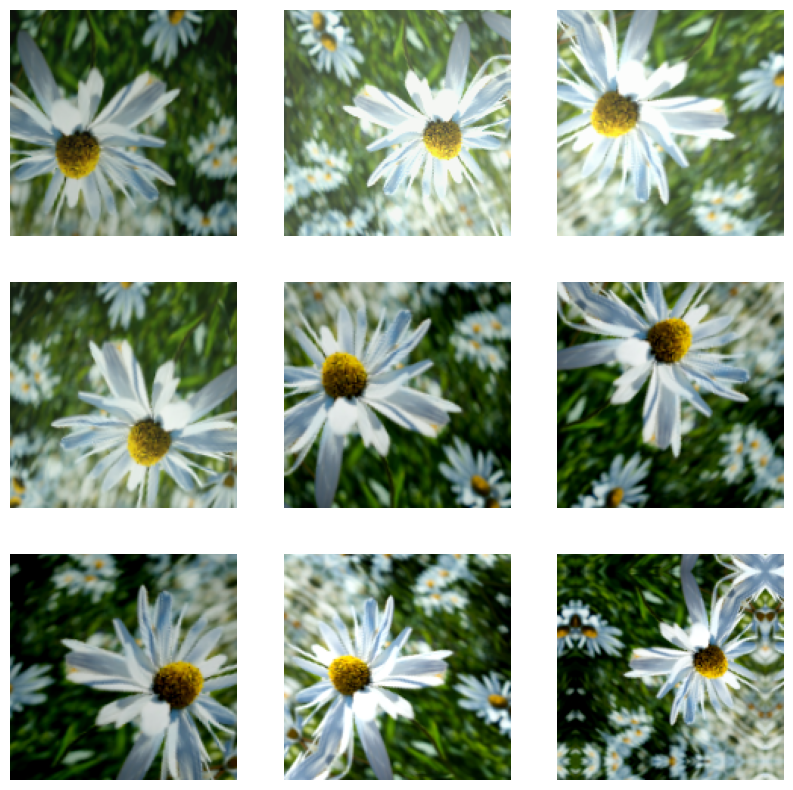

In [15]:
# Set the size of the figure
plt.figure(figsize=(10, 10))
# Take a batch of images from the training dataset
for images, _ in train_ds.take(1):
    # Apply data augmentation to each image in the batch
    for i in range(9):
        augmented_images = data_augmentation(images)
        # Plot the original and augmented images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

plt.show()  # Display the grid of images

# Data pipeline optimization

In [16]:
# Define AUTOTUNE for dynamic buffer size
AUTOTUNE = tf.data.AUTOTUNE

# Optimize the training dataset input pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Cache and prefetch the validation dataset for better performance
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Fully Connected Nural Network Architecture

In [17]:
def make_fcnn_model(input_shape, num_classes):
    # Create the input layer
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)  # Apply data augmentation
    
    # Rescale input data for normalization
    x = layers.Rescaling(1.0/255)(x)

    # Flatten the input data
    x = layers.Flatten()(x)

    # Add dense layers with ReLU activation, batch normalization, and dropout
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Output layer with softmax activation
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = keras.Model(inputs, outputs)
    model.summary()  # Display the model architecture

    return model


In [18]:
model = make_fcnn_model(input_shape=(150, 150, 3), num_classes=5)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 150, 150, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    17,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 17,325,573 (66.09 MB)

 Trainable params: 17,324,613 (66.09 MB)

 Non-trainable params: 960 (3.75 KB)

# Train and save the FCNN

In [19]:
model_file = 'FCNN_model.keras'

# Check if the model is already saved
if os.path.exists(model_file):
    # Load the saved model
    model = keras.models.load_model(model_file)
    print("Model loaded from disk.")
else:
    # Create, compile, and train the model if it doesn't exist

    # Create and compile the model
#     model = make_fcnn_model(input_shape=(150, 150, 3), num_classes=5)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks for early stopping and model checkpointing
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model_checkpoint = keras.callbacks.ModelCheckpoint(
        model_file,  # Save the best model
        monitor='val_loss',
        save_best_only=True
    )

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,  # Increase epochs for better convergence
        callbacks=[early_stopping, model_checkpoint]
    )

    print("Model trained and saved.")


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.2524 - loss: 2.0021 - val_accuracy: 0.1875 - val_loss: 1.8166
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3046 - loss: 1.6743 - val_accuracy: 0.3125 - val_loss: 1.5007
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3156 - loss: 1.5903 - val_accuracy: 0.3625 - val_loss: 1.3782
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3653 - loss: 1.4568 - val_accuracy: 0.4375 - val_loss: 1.3075
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.3836 - loss: 1.4008 - val_accuracy: 0.4000 - val_loss: 1.2632
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3820 - loss: 1.4013 - val_accuracy: 0.4500 - val_loss: 1.3740
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4053 - loss: 1.3874 - val_accuracy: 0.3875 - val_loss: 1.2800
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4038 - loss: 1.3399 - val_acc

# # Model Evaluation FCNN

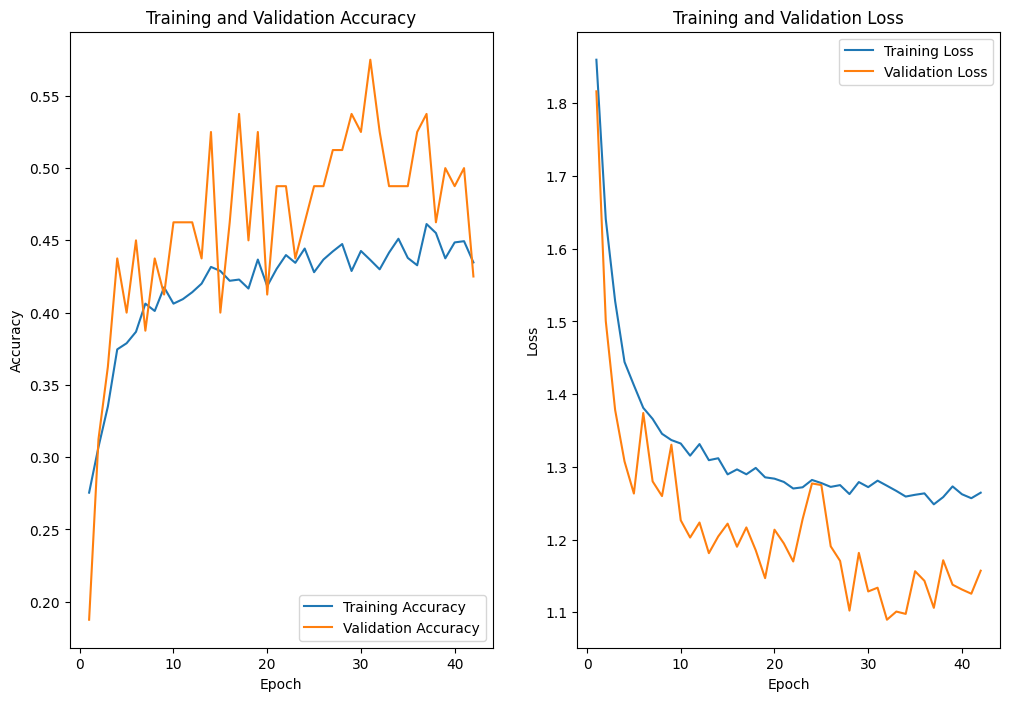

In [20]:
path='fcnn_accuracy-loss_plot.png'
def plot_accuracy_loss(history,path):

    # Check if the plot already exists
    if os.path.exists(path):
        # Display the existing plot
        img = plt.imread(path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
    
        # Get the actual number of epochs trained
        epochs_trained = len(history.history['accuracy'])
        epochs_range = range(1, epochs_trained + 1)

        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        print()

        plt.figure(figsize=(12, 8))

        # Plot for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

        # Plot for loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        # Save the plot to the specified location
        plt.savefig(path)

        # Display the new plot
        plt.show()

# Check if the plot already exists
if os.path.exists(path):
    # Display the existing plot
    img = plt.imread(path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    plot_accuracy_loss(history,'fcnn_accuracy-loss_plot.png')


In [21]:
# Constant list of class names for the dataset
DEFAULT_CLASS_NAMES = [
    'daisy', 'dandelion', 'rose', 'sunflowers', 'tulips'
]

def evaluate_and_plot_confusion_matrix(model, test_ds, conf_matrix_path, class_names=DEFAULT_CLASS_NAMES):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Initialize lists to store true and predicted labels
    y_true = []
    y_pred = []

    # Iterate through the test dataset to collect predictions and true labels
    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(tf.argmax(labels, axis=1).numpy())  # Convert one-hot encoded labels to class indices
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())  # Get predicted class indices

    # Check if a saved confusion matrix exists
    if os.path.exists(conf_matrix_path):
        # Display the existing confusion matrix
        plt.figure(figsize=(10, 8))
        img = plt.imread(conf_matrix_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        # Compute and plot a new confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.savefig(conf_matrix_path)  # Save the confusion matrix as an image
        plt.close()

    # Print the classification report
    class_report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:")
    print(class_report)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8783 - loss: 0.8976 
Test loss: 0.9947
Test accuracy: 0.8800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


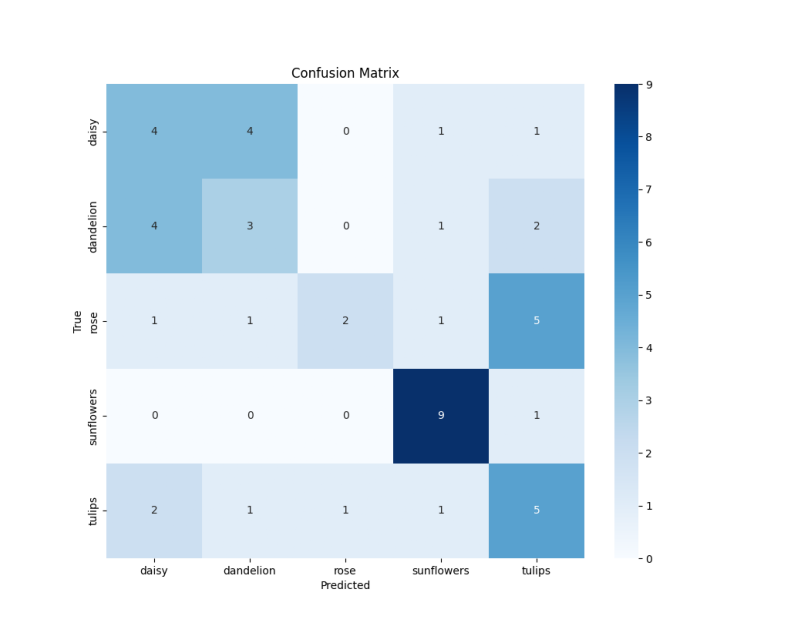

Classification Report:
              precision    recall  f1-score   support

       daisy       0.90      0.90      0.90        10
   dandelion       0.90      0.90      0.90        10
        rose       0.89      0.80      0.84        10
  sunflowers       1.00      1.00      1.00        10
      tulips       0.73      0.80      0.76        10

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50



In [49]:
evaluate_and_plot_confusion_matrix(model, test_ds, 'fcnn_confusion_matrix.png')
plt.show()

In [23]:
class_name=[
    'daisy', 'dandelion', 'rose', 'sunflowers', 'tulips'
]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


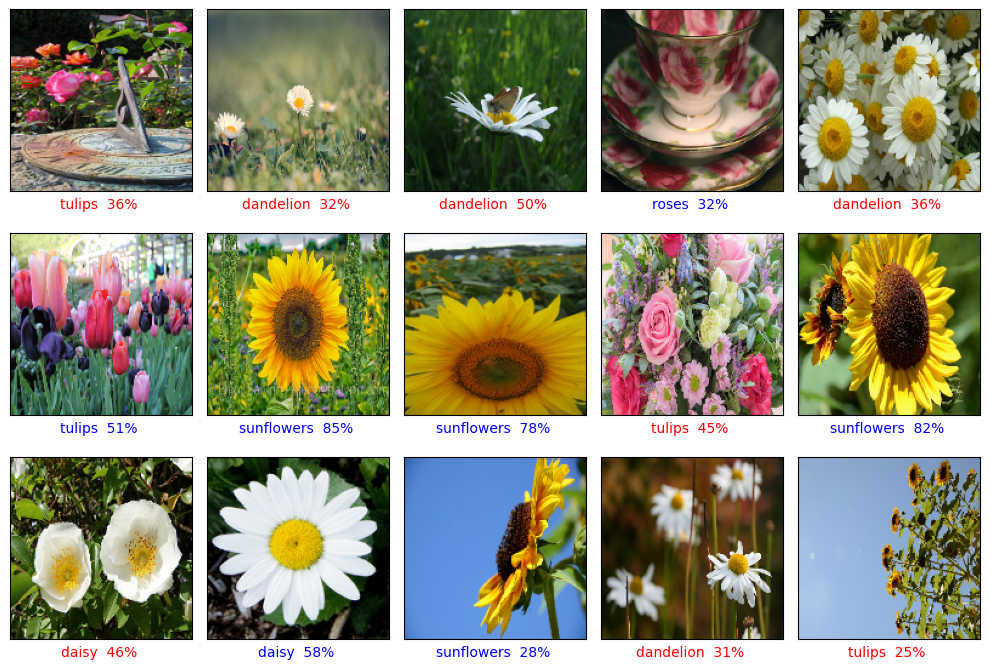

In [24]:
# Function to plot an image along with its predicted label
def plot_image(pred_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.numpy().astype("uint8"))

    pred_label = np.argmax(pred_array)
    # Color labels blue for correct predictions and red for incorrect ones
    color = 'blue' if pred_label == true_label else 'red'
    plt.xlabel("{} {:3.0f}% ".format(class_names[pred_label], 100 * np.max(pred_array)), color=color)

# Function to plot predictions made by the model
def plot_predictions(model):
    # Get true labels and images from the test dataset
    true_categories = tf.concat([tf.argmax(y, axis=1) for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    # Get predicted labels from the model
    y_pred = model.predict(test_ds)
    # Randomly sample 15 test images and plot them with their predicted and true labels
    indices = random.sample(range(len(images)), 15)
    num_rows, num_cols = 3, 5
    plt.figure(figsize=(2*num_cols, int(2.5*num_rows)))
    for i, index in enumerate(indices):
        plt.subplot(num_rows, num_cols, i+1)
        plot_image(y_pred[index], true_categories[index], images[index])
    plt.tight_layout()
    plt.show()

# Plot predictions using the defined function
plot_predictions(model)


# Convulational neural network architecture creation

In [25]:
def make_model(input_shape, num_classes):
    # Define the input layer with data augmentation
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0/255)(x)

    # Convolutional and pooling layers
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flattening and fully connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    # Output layer for classification
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = keras.Model(inputs, outputs)
    print(model.summary())
    return model


In [26]:
model = make_model(input_shape=(150, 150, 3), num_classes=5)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 150, 150, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       663,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737,701 (2.81 MB)

 Trainable params: 737,701 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

None


# Train the model  (CNN)

In [27]:
# Define the file name for the saved model
model_file = 'CNN_model.keras'

# Check if the model is already saved
if os.path.exists(model_file):
    # Load the saved model
    model = keras.models.load_model(model_file)
    print("Model loaded from disk.")
else:
    # If the model doesn't exist, create, compile, and train it

    # Create and compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model_checkpoint = keras.callbacks.ModelCheckpoint(
        model_file,  # Save the best model
        monitor='val_loss',
        save_best_only=True
    )

    # Train the model if it's not already saved
    history=model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping, model_checkpoint]
    )

    print("Model trained and saved.")

Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.2855 - loss: 1.5299 - val_accuracy: 0.5000 - val_loss: 1.1404
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5113 - loss: 1.1967 - val_accuracy: 0.7000 - val_loss: 0.8465
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.5559 - loss: 1.1224 - val_accuracy: 0.6250 - val_loss: 0.9133
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5895 - loss: 1.0589 - val_accuracy: 0.7500 - val_loss: 0.7715
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5952 - loss: 1.0113 - val_accuracy: 0.7625 - val_loss: 0.7694
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.6248 - loss: 0.9895 - val_accuracy: 0.7375 - val_loss: 0.7731
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.6247 - loss: 0.9640 - val_accuracy: 0.7625 - val_loss: 0.7119
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.6584 - loss: 0.8858 - val_ac

# Model Evaluation

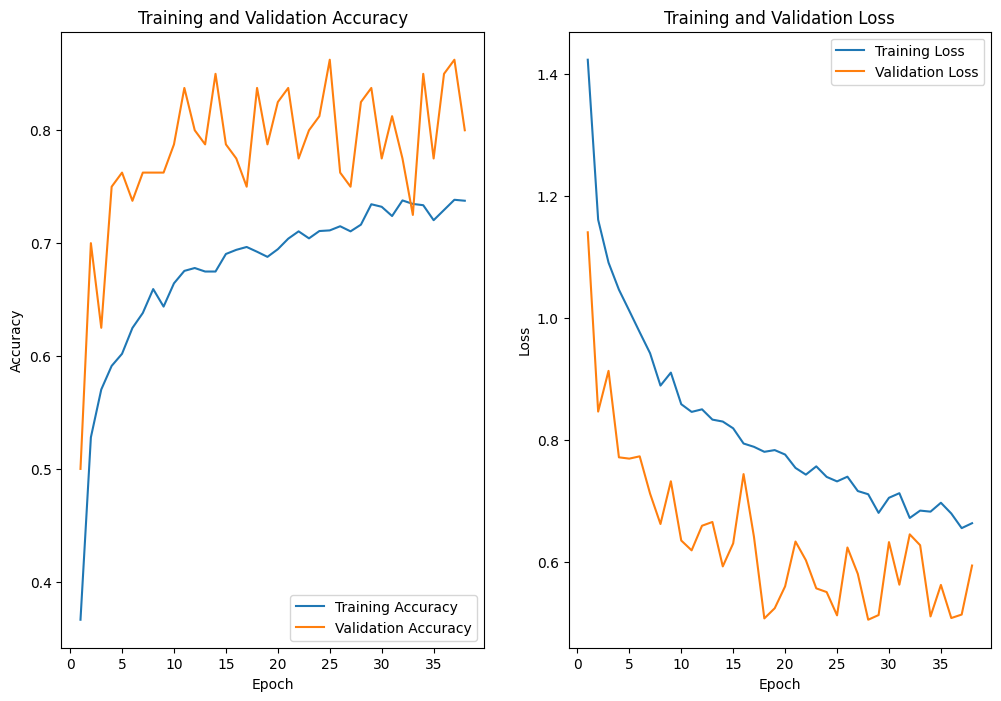

In [28]:
# File path for saving the plot
plot_path = 'cnn_accuracy-loss_plot.png'

def plot_accuracy_loss(history):
    # Check if the plot already exists
    if os.path.exists(plot_path):
        # Display the existing plot
        img = plt.imread(plot_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        # Get the actual number of epochs trained
        epochs_trained = len(history.history['accuracy'])
        epochs_range = range(1, epochs_trained + 1)

        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.figure(figsize=(12, 8))

        # Plot for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

        # Plot for loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        # Save the plot to the specified location
        plt.savefig(plot_path)

        # Display the new plot
        plt.show()

# Check if the plot already exists
if os.path.exists(plot_path):
    # Display the existing plot
    plt.figure(figsize=(10, 8))
    img = plt.imread(plot_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    plot_accuracy_loss(history)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8783 - loss: 0.8976 
Test loss: 0.9947
Test accuracy: 0.8800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


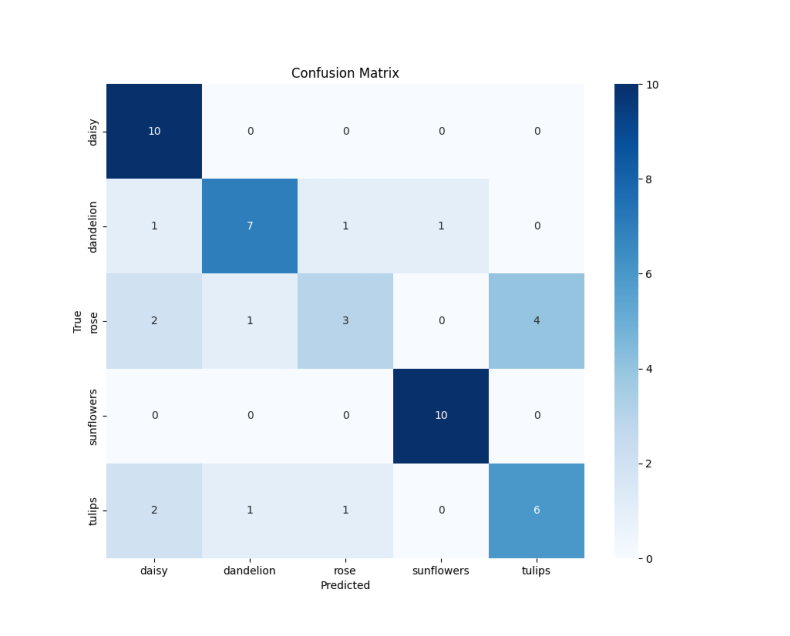

Classification Report:
              precision    recall  f1-score   support

       daisy       0.90      0.90      0.90        10
   dandelion       0.90      0.90      0.90        10
        rose       0.89      0.80      0.84        10
  sunflowers       1.00      1.00      1.00        10
      tulips       0.73      0.80      0.76        10

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50



In [48]:
evaluate_and_plot_confusion_matrix(model, test_ds, 'CNN_confusion_matrix.png')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


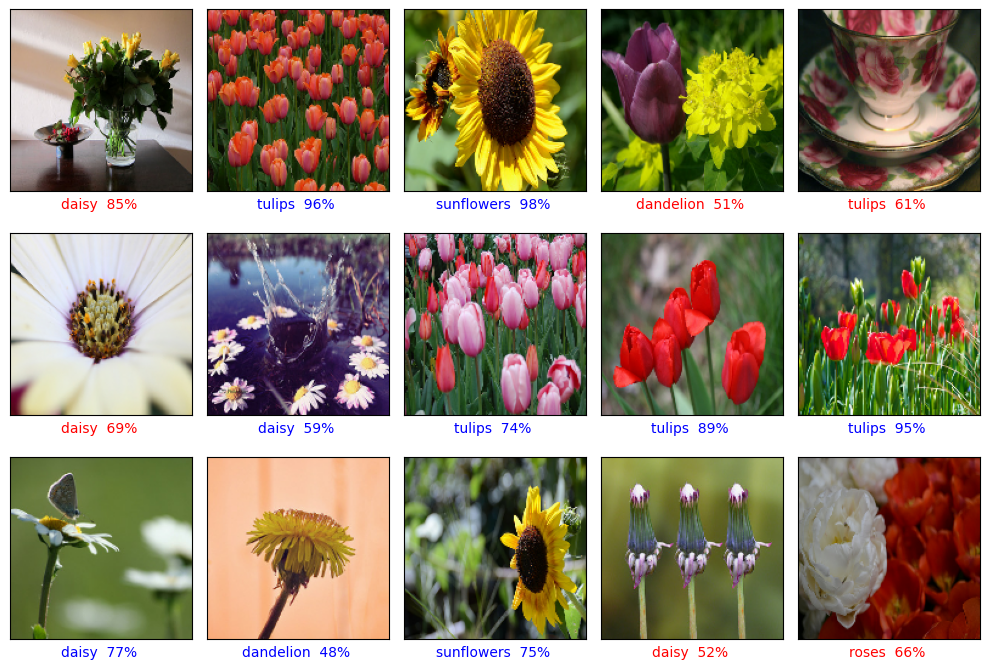

In [30]:
def plot_image(pred_array, true_label, img):
    # Display the image
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.numpy().astype("uint8"))

    # Get the predicted label
    pred_label = np.argmax(pred_array)
    # Set label color based on correctness of prediction
    if pred_label == true_label:
        color = 'blue'  # Correct prediction
    else:
        color = 'red'   # Incorrect prediction
    # Display the label with color
    plt.xlabel("{} {:3.0f}% ".format(class_names[pred_label],
                                      100*np.max(pred_array)),
                                      color=color)

def plot_predictions(model):
    # Concatenate true labels and images from the test dataset
    true_categories = tf.concat([tf.argmax(y, axis=1) for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    # Get predicted labels from the model
    y_pred = model.predict(test_ds)
    
    # Randomly sample 15 test images
    indices = random.sample(range(len(images)), 15)
    # Define grid dimensions
    num_rows, num_cols = 3, 5
    num_images = num_rows*num_cols
    
    # Plot the sampled test images along with predicted and true labels
    plt.figure(figsize=(2*num_cols, int(2.5*num_rows)))
    for i, index in enumerate(indices):
        plt.subplot(num_rows, num_cols, i+1)
        # Plot the image with labels
        plot_image(y_pred[index], true_categories[index], images[index])
    plt.tight_layout()
    plt.show()

# Call the plot_predictions function with the model
plot_predictions(model)


# Transfera Learning

In [38]:
base_model = keras.applications.ResNet50(
        weights='imagenet',  # Load weights trained on ImageNet
        include_top=False,  # Exclude the original top layer
        input_shape=(150, 150, 3)  # Input size
    )
base_model.summary()


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Model Trainning


In [44]:
from tensorflow.keras import models

# File path for the saved model
model_file = "trained_model.keras"

# Check if a pre-trained model is already saved
if os.path.exists(model_file):
    # If the model exists, load it
    model = keras.models.load_model(model_file)
    print("Loaded the existing model.")
else:
    # If the model does not exist, create and train a new one
    print("No existing model found. Creating a new model.")

# Load the pre-trained base model
    base_model = keras.applications.ResNet50(
        weights='imagenet',  # Load weights trained on ImageNet
        include_top=False,  # Exclude the original top layer
        input_shape=(150, 150, 3)  # Expected input size
    )

    #  Restructure the Model
    x = base_model.output  # Start from the output of the base model

    # Apply Global Average Pooling to reduce dimensions
    x = layers.GlobalAveragePooling2D()(x)

    # Add a new dense layer with 256 neurons and ReLU activation
    x = layers.Dense(256, activation='relu')(x)

    # Add a dropout layer for regularization to reduce overfitting
    x = layers.Dropout(0.4)(x)

    # Add the final dense layer with softmax activation for a 15-class problem
    output_layer = layers.Dense(5, activation='softmax')(x)

    # Create the new model
    model = models.Model(inputs=base_model.input, outputs=output_layer)

    # Freeze the base model's layers to keep pre-trained weights intact
    for layer in base_model.layers:
        layer.trainable = False
    base_model.summary()
    # Compile the model with a loss function, optimizer, and metrics
    model.compile(
        optimizer='adam',  # Adam optimizer
        loss='categorical_crossentropy',  # Loss for multi-class classification
        metrics=['accuracy']  # Metric to track during training
    )

    #  Train the Model (Fine-Tuning)
    history = model.fit(
        train_ds,  # Training dataset
        validation_data=val_ds,  # Validation dataset
        epochs=10  # Number of epochs
    )

    # Save the trained model
    model.save(model_file)
    print("Model trained and saved.")


No existing model found. Creating a new model.


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
  3/111 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.1701 - loss: 3.4776 

W0000 00:00:1715607441.549212     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 26/111 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 0.4451 - loss: 2.1186

W0000 00:00:1715607446.710546     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6298 - loss: 1.2438

W0000 00:00:1715607454.337080     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.6317 - loss: 1.2357 - val_accuracy: 0.8500 - val_loss: 0.4606
Epoch 2/10
  3/111 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7604 - loss: 0.4999

W0000 00:00:1715607456.162990     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8509 - loss: 0.3980 - val_accuracy: 0.8625 - val_loss: 0.4425
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8925 - loss: 0.2782 - val_accuracy: 0.8625 - val_loss: 0.3825
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9114 - loss: 0.2249 - val_accuracy: 0.8625 - val_loss: 0.3708
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9246 - loss: 0.2079 - val_accuracy: 0.8375 - val_loss: 0.3709
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9411 - loss: 0.1594 - val_accuracy: 0.8500 - val_loss: 0.3677
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9586 - loss: 0.1230 - val_accuracy: 0.8750 - val_loss: 0.2827
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9560 - loss: 0.1164 - val_accuracy: 0.8625 - val_loss: 0.3750
Epoch 9/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9681 - loss: 0.1014 - val_accuracy: 0.887

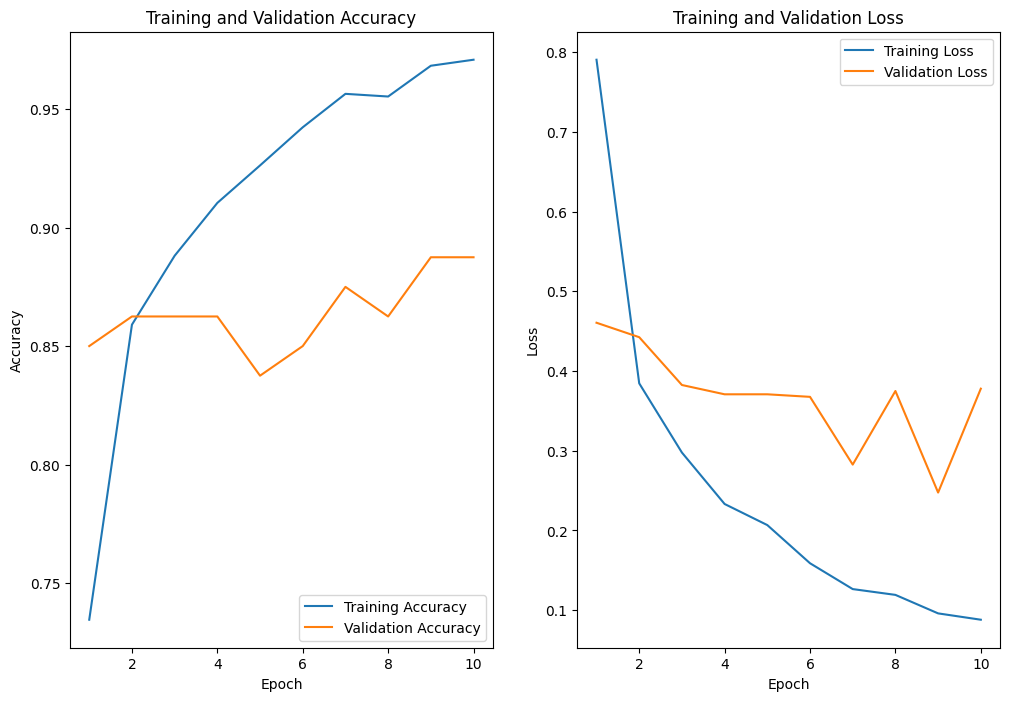

In [45]:
#file_path
plot_path = 'tl_accuracy-loss_plot.png'
def plot_accuracy_loss(history):

    # Check if the plot already exists
    if os.path.exists(plot_path):
        # Display the existing plot
        img = plt.imread(plot_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        # Get the actual number of epochs trained
        epochs_trained = len(history.history['accuracy'])
        epochs_range = range(1, epochs_trained + 1)

        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.figure(figsize=(12, 8))

        # Plot for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')        
        plt.ylabel('Accuracy')


        # Plot for loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')


        # Save the plot to the specified location
        plt.savefig(plot_path)

        # Display the new plot
        plt.show()

# Check if the plot already exists
if os.path.exists(plot_path):
    # Display the existing plot
    img = plt.imread(plot_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    plot_accuracy_loss(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8783 - loss: 0.8976 
Test loss: 0.9947
Test accuracy: 0.8800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


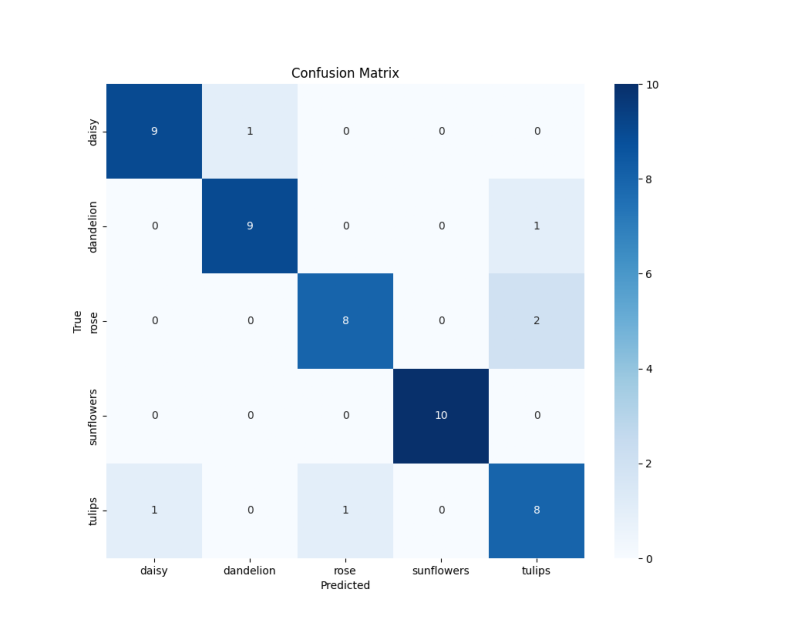

Classification Report:
              precision    recall  f1-score   support

       daisy       0.90      0.90      0.90        10
   dandelion       0.90      0.90      0.90        10
        rose       0.89      0.80      0.84        10
  sunflowers       1.00      1.00      1.00        10
      tulips       0.73      0.80      0.76        10

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50



In [47]:
evaluate_and_plot_confusion_matrix(model, test_ds, 'tl_confusion_matrix.png')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


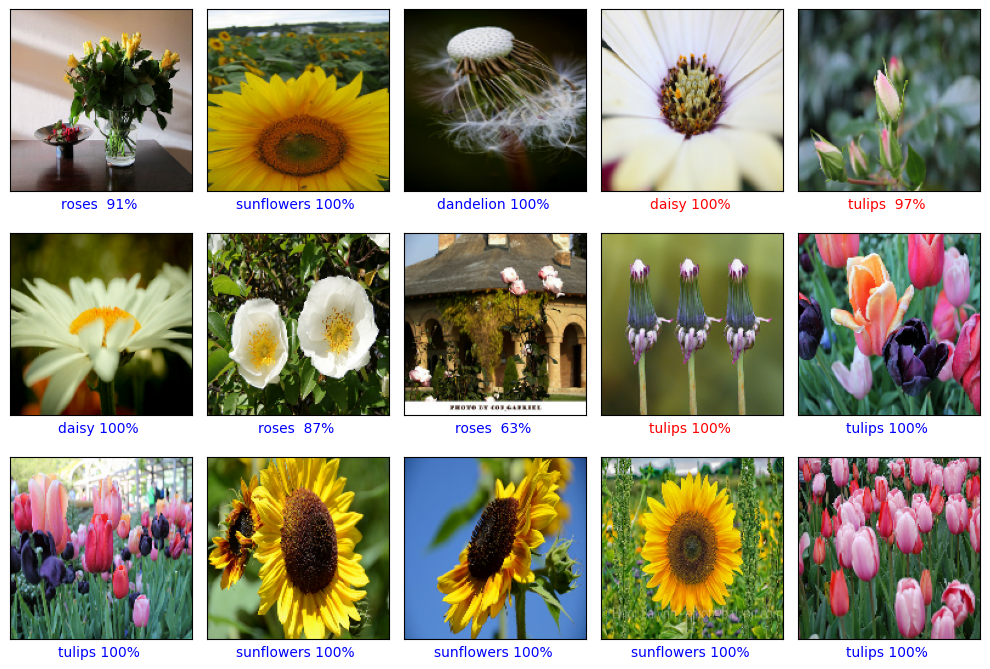

In [52]:
# Define functions to visualize class-specific accuracies
def visualize_image_predictions(pred_array, true_label, img):
    # Display the image without grid lines or ticks
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.numpy().astype("uint8"))

    # Determine the predicted label and color-code it based on correctness
    pred_label = np.argmax(pred_array)
    if pred_label == true_label:
        text_color = 'blue'
    else:
        text_color = 'red'
    # Display the predicted label with its confidence percentage
    plt.xlabel("{} {:3.0f}% ".format(class_names[pred_label],
                                    100*np.max(pred_array)),
                                    color=text_color)

def visualize_predictions(model):
    # Concatenate true labels and images from the test dataset
    true_labels = tf.concat([tf.argmax(y, axis=1) for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    # Predict labels for the test dataset
    predicted_labels = model.predict(test_ds)
    # Randomly select 15 test images and display them with predicted and true labels
    random_indices = random.sample(range(len(images)), 15)
    # Arrange the images in a grid with colored labels indicating correctness
    num_rows, num_cols = 3, 5
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*num_cols, int(2.5*num_rows)))
    for i, index in enumerate(random_indices):
        plt.subplot(num_rows, num_cols, i+1)
        visualize_image_predictions(predicted_labels[index], true_labels[index], images[index])
    plt.tight_layout()
    plt.show()

# Visualize predictions made by the model
visualize_predictions(model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


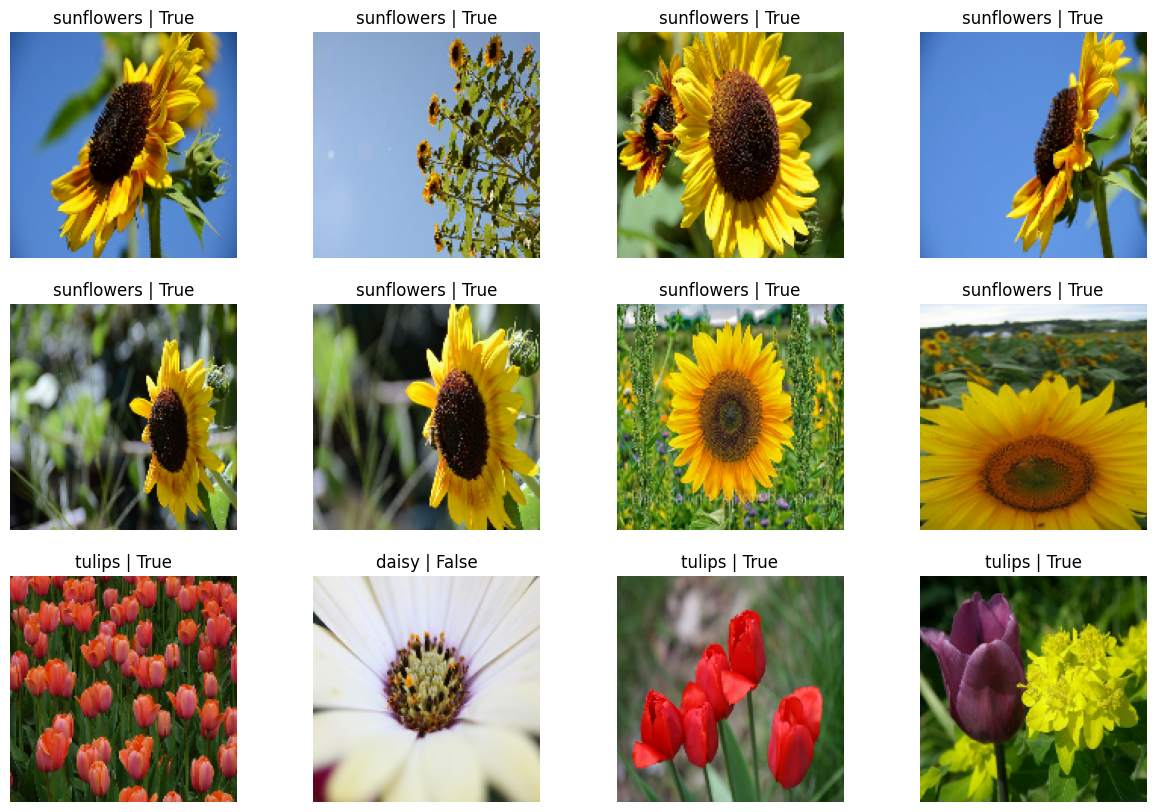

In [55]:
# Display the first 9 images in the training dataset along with their predicted labels
plt.figure(figsize=(15, 10))
for images, labels in test_ds.take(10):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        is_correct = str(predicted_labels[i] == np.argmax(labels[i]))
        plt.title(f"{class_names[predicted_labels[i]]} | {is_correct}")  # Show the predicted label and whether it's correct
        plt.axis("off")



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4213 - loss: 1.2235 
1/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.6562 - loss: 4.9814

W0000 00:00:1715609146.941151     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6854 - loss: 4.2079


W0000 00:00:1715609148.654273     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8750 - loss: 0.7033

W0000 00:00:1715609153.738437     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8783 - loss: 0.8976


W0000 00:00:1715609155.485725     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


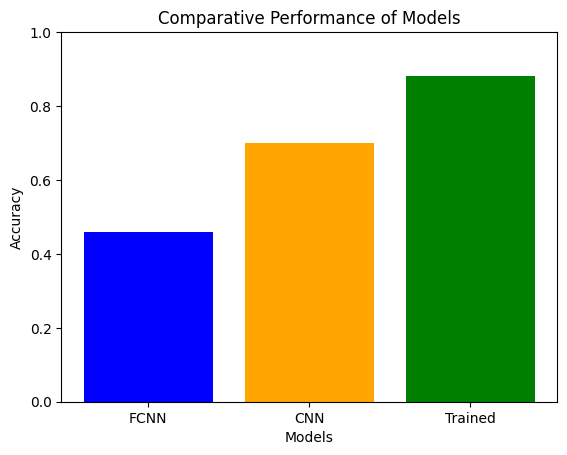

The best performing model is: Trained


In [60]:
# Load models
FCNN = keras.models.load_model('FCNN_model.keras')
CNN = keras.models.load_model('CNN_model.keras')
Tl = keras.models.load_model('trained_model.keras')

models = [FCNN, CNN, Tl]

# Define a function to evaluate the models
def evaluate_model(model, test_ds):
    # Evaluate the model
    evaluation_result = model.evaluate(test_ds)
    return evaluation_result[1]  # Return the accuracy

# Evaluate the models
accuracies = []
for model in models:
    accuracy = evaluate_model(model, test_ds)
    accuracies.append(accuracy)

# Plot the comparative performance
model_names = ['FCNN', 'CNN', 'Trained']
plt.bar(model_names, accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparative Performance of Models')
plt.ylim(0, 1)
plt.show()

# Determine the best-performing model
best_model_index = np.argmax(accuracies)
best_model = model_names[best_model_index]
print(f"The best performing model is: {best_model}")
